In [1]:
from matplotlib import pyplot, patches
import csv
import os
from PIL import Image
from torchvision.models import ResNet50_Weights
import json
import math
import random
from mlt.preexperiments.data_readers import PreprocessScratch

In [2]:
def recalculate_pixels(target_pixels, image_size, preprocess):
    new_x, new_y = target_pixels
    image_x, image_y = image_size
    
    if len(preprocess.resize_size) == 1:
        resize_x = preprocess.resize_size[0]
        resize_y = preprocess.resize_size[0]
    else:
        resize_x, resize_y = preprocess.resize_size
    
    cropped_image_x = min(image_x, resize_x)
    cropped_image_y = min(image_y, resize_y)
    
    if preprocess.crop_size != None:
        new_x = float(new_x + ((cropped_image_x - preprocess.crop_size[0]) / 2))
        new_y = float(new_y + ((cropped_image_y - preprocess.crop_size[0]) / 2))

    new_x = float(new_x * (image_x / cropped_image_x))
    new_y = float(new_y * (image_y / cropped_image_y))
    
    return new_x, new_y

In [3]:
def show_picture(file, dataset_root_dir, number, preprocess, choose_random=True):
    with open(file, 'r', encoding='utf-8') as f:
        content = list(csv.reader(f, delimiter=','))[1:]

        if choose_random:
            images = random.sample(content, number)
        else:
            images = content[:number]
        
        number_cols = 3
        number_rows = math.ceil(number / number_cols)
        fig, ax = pyplot.subplots(nrows=number_rows, ncols=number_cols)
        fig.set_figwidth(5 * number_cols)
        fig.set_figheight(3 * number_rows)
        fig.tight_layout()
        
        for index, (image_id, x, y, target_x, target_y) in enumerate(images):            
            x, y, target_x, target_y = float(x), float(y), float(target_x), float(target_y)
            
            image = Image.open(os.path.join(dataset_root_dir, 'images/', image_id) + '.png')
            
            x, y = recalculate_pixels((x, y), image.size, preprocess)
            target_x, target_y = recalculate_pixels((target_x, target_y), image.size, preprocess)

            plot_x = int(index/number_cols)
            plot_y = index % number_cols

            if number_rows == 1:
                grid_coords = plot_y
            else:
                grid_coords = plot_x, plot_y

            ax[grid_coords].imshow(image)
            ax[grid_coords].set_title(image_id)
            ax[grid_coords].add_patch(patches.Circle((x, y), 5, linewidth=2, edgecolor='r', facecolor='none'))
            ax[grid_coords].add_patch(patches.Circle((target_x, target_y), 5, linewidth=2, edgecolor='g', facecolor='none'))

            ax[grid_coords].text(10, 20, f'distance: {round(math.dist((x, y), (target_x, target_y)), 2)}')

        pyplot.show()


In [4]:
def show_distribution(file, dataset_root_dir, preprocess):
    with open(file, 'r', encoding='utf-8') as f:
        content = csv.reader(f, delimiter=',')

        first_image_path = os.listdir(os.path.join(dataset_root_dir, 'images/'))[0]
        first_image = Image.open(os.path.join(dataset_root_dir, 'images/', first_image_path))
        image_size = first_image.size
        general_fig, general_ax = pyplot.subplots()
        general_ax.imshow(first_image)

        next(content)
        for image_id, x, y, target_x, target_y in content:            
            x, y, target_x, target_y = float(x), float(y), float(target_x), float(target_y)
                        
            x, y = recalculate_pixels((x, y), image_size, preprocess)
            target_x, target_y = recalculate_pixels((target_x, target_y), image_size, preprocess)

            general_ax.add_patch(patches.Circle((x, y), 1, linewidth=2, edgecolor='r', facecolor='none'))
            general_ax.add_patch(patches.Circle((target_x, target_y), 1, linewidth=2, edgecolor='g', facecolor='none'))

        pyplot.show()


In [5]:
preprocess_pretrained = ResNet50_Weights.DEFAULT.transforms()
preprocess_scratch = PreprocessScratch(250)

In [6]:
# project_root_dir = '/home/guskunkdo@GU.GU.SE/MLT_Master-Thesis/'
# project_root_dir = '/home/dominik/Nextcloud/020_Masterstudium/Language Technology/LT2402_Master Thesis/experiments/runs/language-games/'
project_root_dir = '/home/dominik/Development/MLT_Master-Thesis/out/'
model_dir = os.path.join(project_root_dir, '2023-11-09_14-57-19_dale_attribute_coordinate_predictor_dale-2_250_1024_1000_30_0.00003/')
# dataset_image_dir = '/scratch/guskunkdo/clevr-images-unambigous-colour/'
dataset_image_dir = '/home/dominik/Development/clevr-images-unambigous-dale-two/'
preprocess = preprocess_pretrained

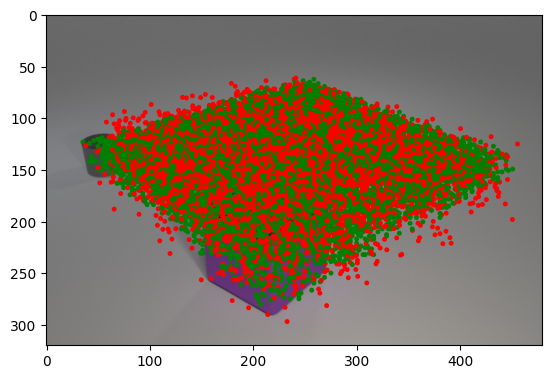

In [7]:
show_distribution(os.path.join(model_dir, 'train_outputs.csv'), dataset_image_dir, preprocess)

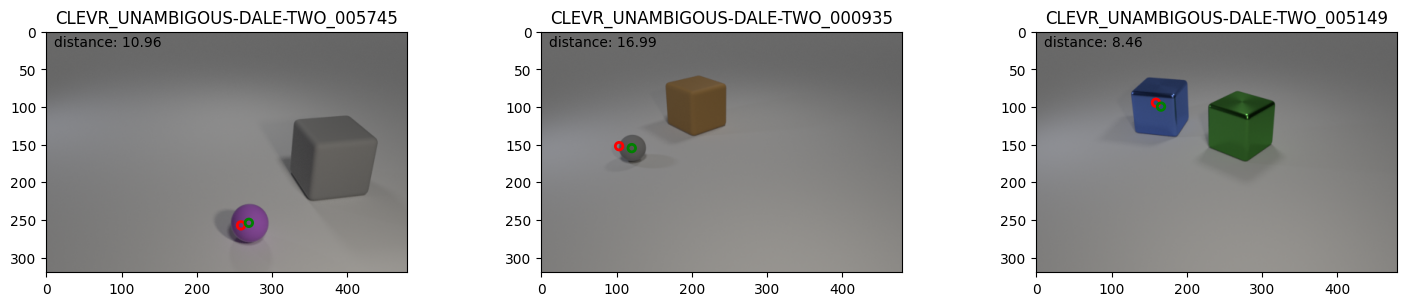

In [8]:
show_picture(os.path.join(model_dir, 'train_outputs.csv'), dataset_image_dir, 3, preprocess)

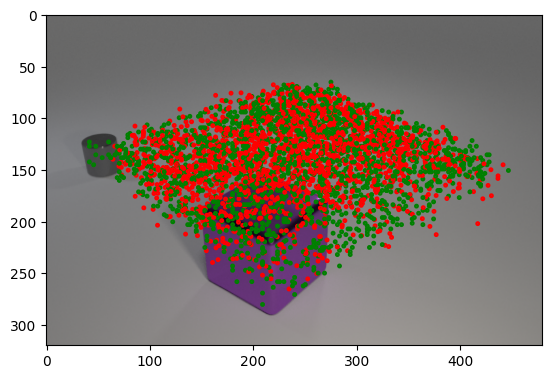

In [9]:
show_distribution(os.path.join(model_dir, 'test_outputs.csv'), dataset_image_dir, preprocess)

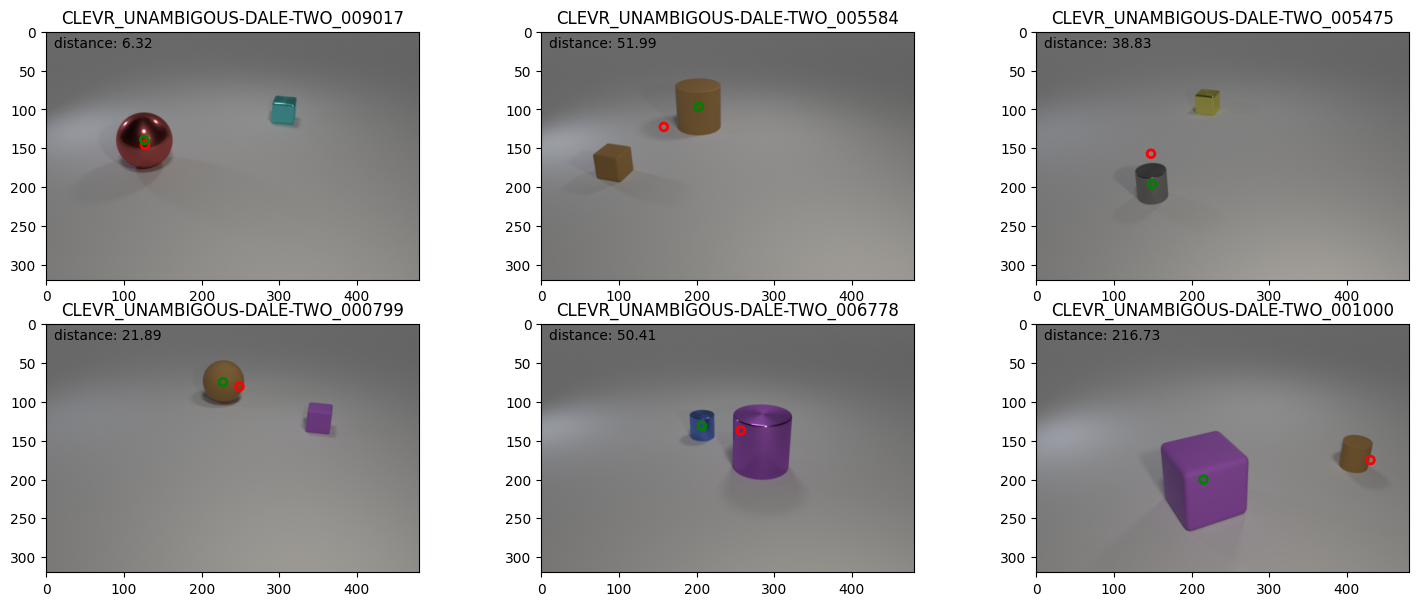

In [12]:
show_picture(os.path.join(model_dir, 'test_outputs.csv'), dataset_image_dir, 6, preprocess)